In [1]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import json

In [2]:
# Initialization
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from nuimages import NuImages

# Load NuImages
nuim_mini = NuImages(dataroot='/root/data/nuimages/images/', version='v1.0-mini', verbose=True, lazy=False)

Loading nuImages tables for version v1.0-mini...
Loaded 12 attribute(s) in 0.008s,
Loaded 50 calibrated_sensor(s) in 0.003s,
Loaded 25 category(s) in 0.001s,
Loaded 650 ego_pose(s) in 0.012s,
Loaded 44 log(s) in 0.000s,
Loaded 506 object_ann(s) in 0.003s,
Loaded 50 sample(s) in 0.000s,
Loaded 650 sample_data(s) in 0.003s,
Loaded 6 sensor(s) in 0.000s,
Loaded 58 surface_ann(s) in 0.011s,
Done loading in 0.041 seconds (lazy=False).


In [3]:
NUM_CATEGORY = len(nuim_mini.category)

# List all the categories
for cate in nuim_mini.category:
    print(cate['name'])

# Dictionary to find category name according to the token
category_to_name = dict()
# Dictionary to find the category index according to category name
category_to_index = dict()
# Dictionary to find the category name according to category index
index_to_category = dict()

for i, cate in enumerate(nuim_mini.category):
    category_to_name.update({cate['token'] : cate['name']})
    category_to_index.update({cate['name'] : i})
    index_to_category.update({i : cate['name']})

# Dictionary to find image's filename according to the token
token_to_filename = dict()

for sample in nuim_mini.sample:
    # Get filename
    # filename = nuim_train.get('sample_data', sample['key_camera_token'])['filename'].split('/')[-1].split('.')[0]
    # Get full path
    filename = nuim_mini.get('sample_data', sample['key_camera_token'])['filename'].split('.')[0]
    token_to_filename.update({sample['key_camera_token'] : filename})

# Image size
WIDTH = 1600
HEIGHT = 900

# Data dictionary
mini_set = dict()

# Transfer
for ob in nuim_mini.object_ann:
    # Get the token of the sample that contains the object
    sample_data_token = ob['sample_data_token']
    
    if ob['mask'] is None:
        continue
    # Get sample's filename
    filename = token_to_filename[sample_data_token]
    # Look up category name of the object
    category = category_to_name[ob['category_token']]
    # bbox format: [xmin, ymin, xmax, ymax]
    bbox = ob['bbox']
    # Transfer bbox to: [x_center_in_ratio, y_center_in_ratio, width_in_ratio, height_in_ratio]
    x_center = ((bbox[0] + bbox[2]) / 2) / WIDTH
    y_center = ((bbox[1] + bbox[3]) / 2) / HEIGHT
    width = (bbox[2] - bbox[0]) / WIDTH
    height = (bbox[3] - bbox[1]) / HEIGHT
    bbox = [x_center, y_center, width, height]

    # Get the category index according to category name
    index = category_to_index[category]
    
    # If the image is visited
    if sample_data_token in mini_set:
        if category in mini_set[sample_data_token]:
            mini_set[sample_data_token][category].append(bbox)
        else:
            mini_set[sample_data_token].update({category : [bbox]})
    # Image not visited
    else:
        mini_set.update({sample_data_token : {category : [bbox]}})


animal
flat.driveable_surface
human.pedestrian.adult
human.pedestrian.child
human.pedestrian.construction_worker
human.pedestrian.personal_mobility
human.pedestrian.police_officer
human.pedestrian.stroller
human.pedestrian.wheelchair
movable_object.barrier
movable_object.debris
movable_object.pushable_pullable
movable_object.trafficcone
static_object.bicycle_rack
vehicle.bicycle
vehicle.bus.bendy
vehicle.bus.rigid
vehicle.car
vehicle.construction
vehicle.ego
vehicle.emergency.ambulance
vehicle.emergency.police
vehicle.motorcycle
vehicle.trailer
vehicle.truck


In [4]:
# ! rm -rf /root/data/nuimages/labels
# ! cd /root/data/nuimages && mkdir labels labels/samples
# ! cd /root/data/nuimages/labels/samples && mkdir CAM_BACK CAM_BACK_LEFT CAM_BACK_RIGHT CAM_FRONT CAM_FRONT_LEFT CAM_FRONT_RIGHT

folder = '/root/data/nuimages/labels/'
for sample in nuim_mini.sample:
    token = sample['key_camera_token']
    filename = token_to_filename[token]
    if token in mini_set:
        with open(folder + filename + '.txt', 'w') as f:
            for cate in mini_set[token].keys():
                index = category_to_index[cate]
                for obj in mini_set[token][cate]:
                    f.write(f'{index} {obj[0]:.6f} {obj[1]:.6f} {obj[2]:.6f} {obj[3]:.6f}\n')
    # There are some samples without annotations
    else:
        open(folder + filename + '.txt', 'w')

! cd /root/data/nuimages && rm -rf mini.txt
folder = '/root/data/nuimages/images/'

path = '/root/data/nuimages/mini.txt'
with open(path, 'w') as f:
    for sample in nuim_mini.sample:
        filename = folder + nuim_mini.get('sample_data', sample['key_camera_token'])['filename']  
        f.write(filename + '\n')

UnboundLocalError: local variable 'child' referenced before assignment

In [ ]:
# Create dataset for decision tree training
! python3 feature_mining/create_dataset.py --data 'data/nuimages_mini.yaml' --filename 'activation_outputs/mini_35.pt'

cpu
{'train': '/root/data/nuimages/mini.txt', 'val': '/root/data/nuimages/mini.txt', 'test': '/root/data/nuimages/mini.txt', 'nc': 25, 'names': ['animal', 'flat.driveable_surface', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris', 'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.ego', 'vehicle.emergency.ambulance', 'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck']}
Scanning labels /root/data/nuimages/labels/samples/CAM_BACK.cache3 (50 found, 0 missing, 0 empty, 0 duplicate, for 50 images): 50it [00:00, 11651.49it/s]
  0%|                                                    | 0

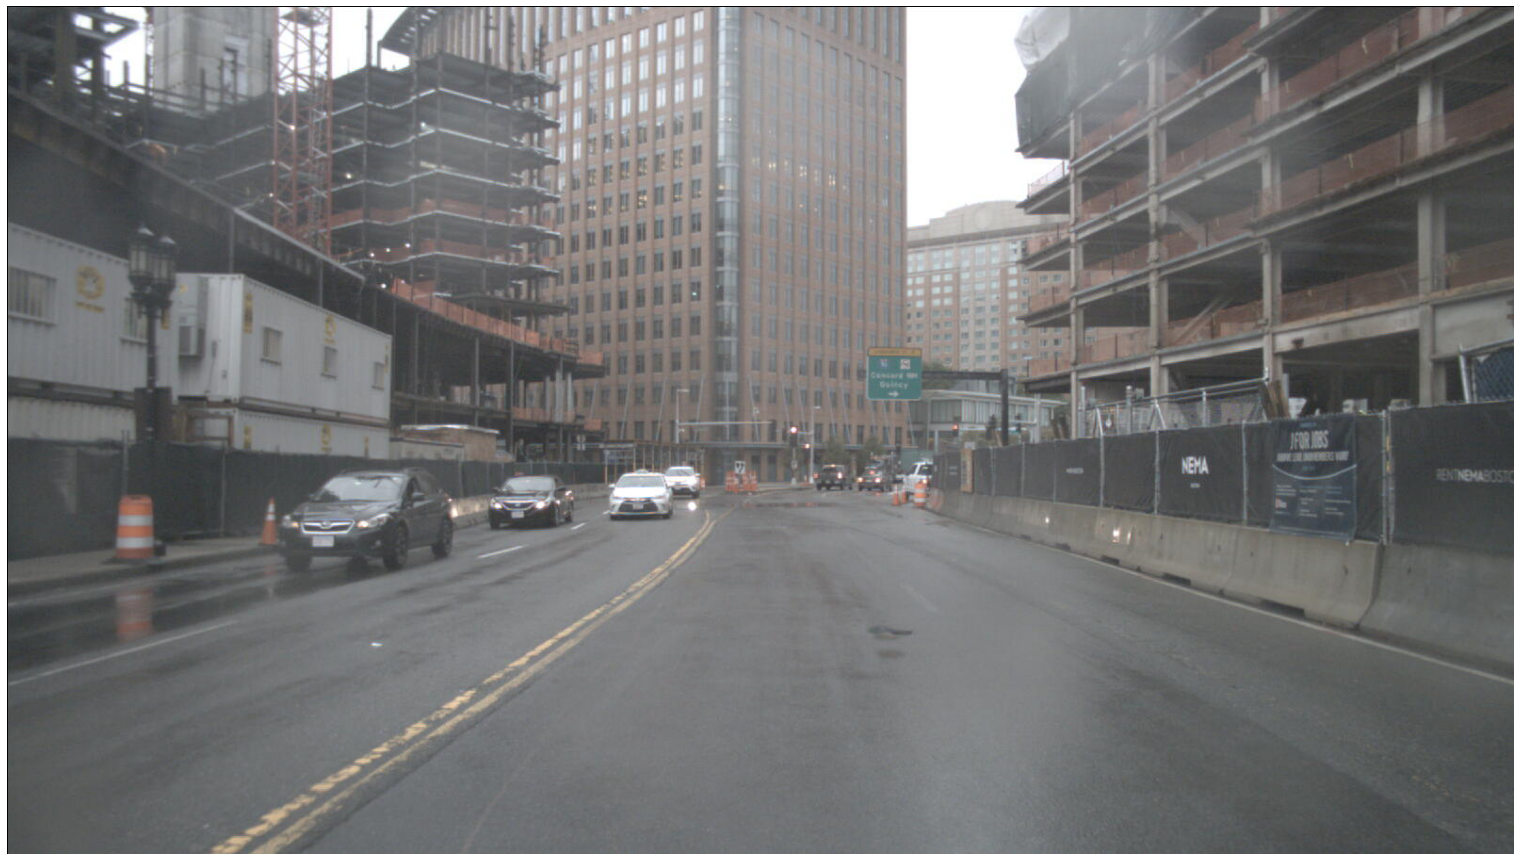

In [ ]:
# See if there is junctions in sample 45
key_camera_token = nuim_mini.sample[45]['key_camera_token']
nuim_mini.render_image(key_camera_token, annotation_type='none', with_category=True, with_attributes=True, box_line_width=-1, render_scale=3)

In [ ]:
junction = [True, False, False, False, False, True, False, False, False, False, False, False, False, True, False, True, True, False, False, True, False, False, False, True, False, False, True, False, False, False, False, True, False, False, False, True, False, True, True, False, False, False, True, False, False, False, False, False, False, False]
data = torch.load('activation_outputs/mini_35.pt')
activation_outputs = data['data'].numpy()
mAPs = data['label']

In [ ]:
num_train = 25
x_train = activation_outputs[:num_train]
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = junction[:num_train]

x_test = activation_outputs[num_train:]
x_test = x_test.reshape(x_test.shape[0], -1)
y_test = junction[num_train:]

In [ ]:
from sklearn import tree

basic_estimator = tree.DecisionTreeClassifier()
basic_estimator.fit(x_train, y_train)
y_pred = basic_estimator.predict(x_test)


DecisionTreeClassifier()

In [ ]:
# Train tree for every attributes


# Select the pure node with highest support of the tree


# Get path to the pure nodes


# Extract rules of the path



In [69]:
print('pred\tlabel')
for pred, label in zip(y_pred, y_test):
    print(pred, end='\t')
    print(label)
print(f'correct: {(y_pred == y_test).tolist().count(True)}')


pred	label
True	False
True	True
False	False
False	False
True	False
True	False
False	True
False	False
False	False
False	False
False	True
False	False
False	True
False	True
True	False
False	False
False	False
True	True
True	False
False	False
False	False
False	False
False	False
False	False
False	False
correct: 16
